# Paysim Dataset analysis (fraud detection)
## CSE 547 Spring 2017
### Brian de Silva and Daiwei He

In [2]:
# Import packages we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
# Read in the data
paysim_data = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [4]:
# Print out some basic information
print "Data has %d rows and %d columns" %(paysim_data.shape)

if paysim_data.isnull().values.any():
    print "Data has missing values!"
else:
    print "Data does not have missing vlues.\n\n"
    
# Let's have a look at what the data actually looks like
print('-----------------------------------------------------------------\nHead:')
print(paysim_data.head())
print("-----------------------------------------------------------------\nDescribe:")
print(paysim_data.describe())
print("-----------------------------------------------------------------\nInfo:")
print(paysim_data.info())

Data has 6362620 rows and 11 columns
Data does not have missing vlues.


-----------------------------------------------------------------
Head:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0    

In [5]:
# Check number of fraudulent transactions
fraudCount = paysim_data['isFraud'].sum()
print "Total number of fraudulent transactions: %d" %fraudCount
print "Percentage of all transactions: %f" %(100.0 * float(fraudCount) / paysim_data.shape[0])

Total number of fraudulent transactions: 8213
Percentage of all transactions: 0.129082


It looks like there are very few fraudulent transactions in the set. How many transactions were flagged by the system?

In [6]:
print "Total number of flagged transactions: %d" %paysim_data['isFlaggedFraud'].sum()

Total number of flagged transactions: 16


Not many... Let's dig into some of the features. First up are the transaction types.

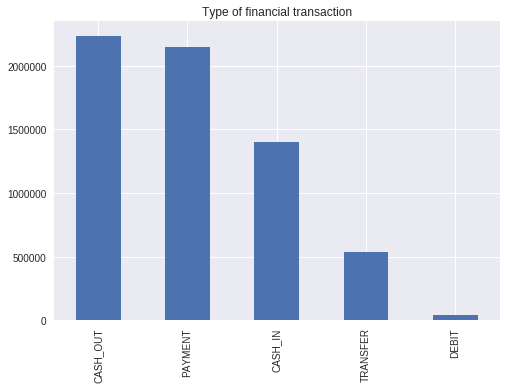

PAYMENT:	0 cases of fraud of 2151495 total (0.000000)
TRANSFER:	4097 cases of fraud of 532909 total (0.007688)
CASH_OUT:	4116 cases of fraud of 2237500 total (0.001840)
DEBIT:	0 cases of fraud of 41432 total (0.000000)
CASH_IN:	0 cases of fraud of 1399284 total (0.000000)


In [7]:
paysim_data.type.value_counts().plot(kind='bar',title='Type of financial transaction')
plt.show()

for trans_type in paysim_data['type'].unique():
    nFraud = paysim_data[paysim_data['type']==trans_type]['isFraud'].sum()
    nTotal = paysim_data[paysim_data['type']==trans_type].shape[0]
    print "%s:\t%d cases of fraud of %d total (%f)" %(trans_type, nFraud, nTotal, float(nFraud)/nTotal)

In [10]:
# dups = paysim_data.duplicated('nameDest').values
# dup_dest = set(paysim_data.loc[dups,'nameDest'])
# inds = [dest in dup_dest for dest in paysim_data.nameDest]

orig_cts = paysim_data.nameOrig.value_counts()
dest_cts = paysim_data.nameDest.value_counts()
paysim_data.loc['nOrigTransactions'] = 0
paysim_data.loc['nDestTransactions'] = 0
for idx, row in paysim_data.iterrows():
    row['nOrigTransactions'] = orig_cts[row['nameOrig']]-1
    row['nDestTransactions'] = dest_cts[row['nameDest']]-1


print paysim_data


KeyboardInterrupt: 

There are no cases of fraud among the payment, debit, or cash_in transaction types.

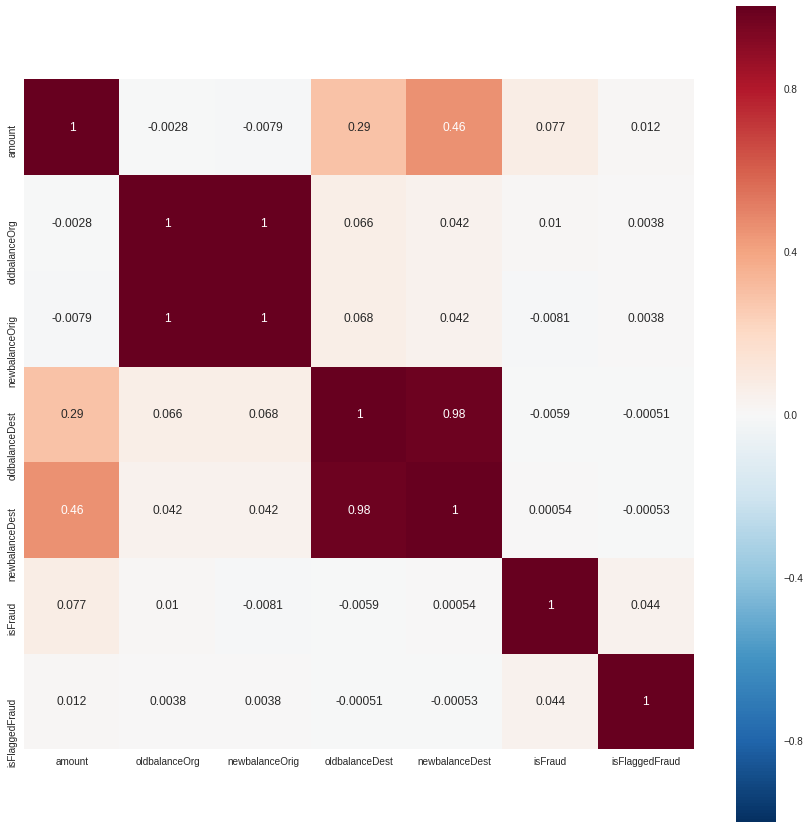

In [87]:
corr_cols = ['type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']
# corr = paysim_data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(paysim_data[corr_cols].corr(), square=True, annot=True)
plt.show()

None of these correlations are especially illuminating. The feature most highly correlated with a transaction being fraudulent is if it has been flagged as being fraudulent--though this correlation is weak. After that the amount appears to have the largest correlation.

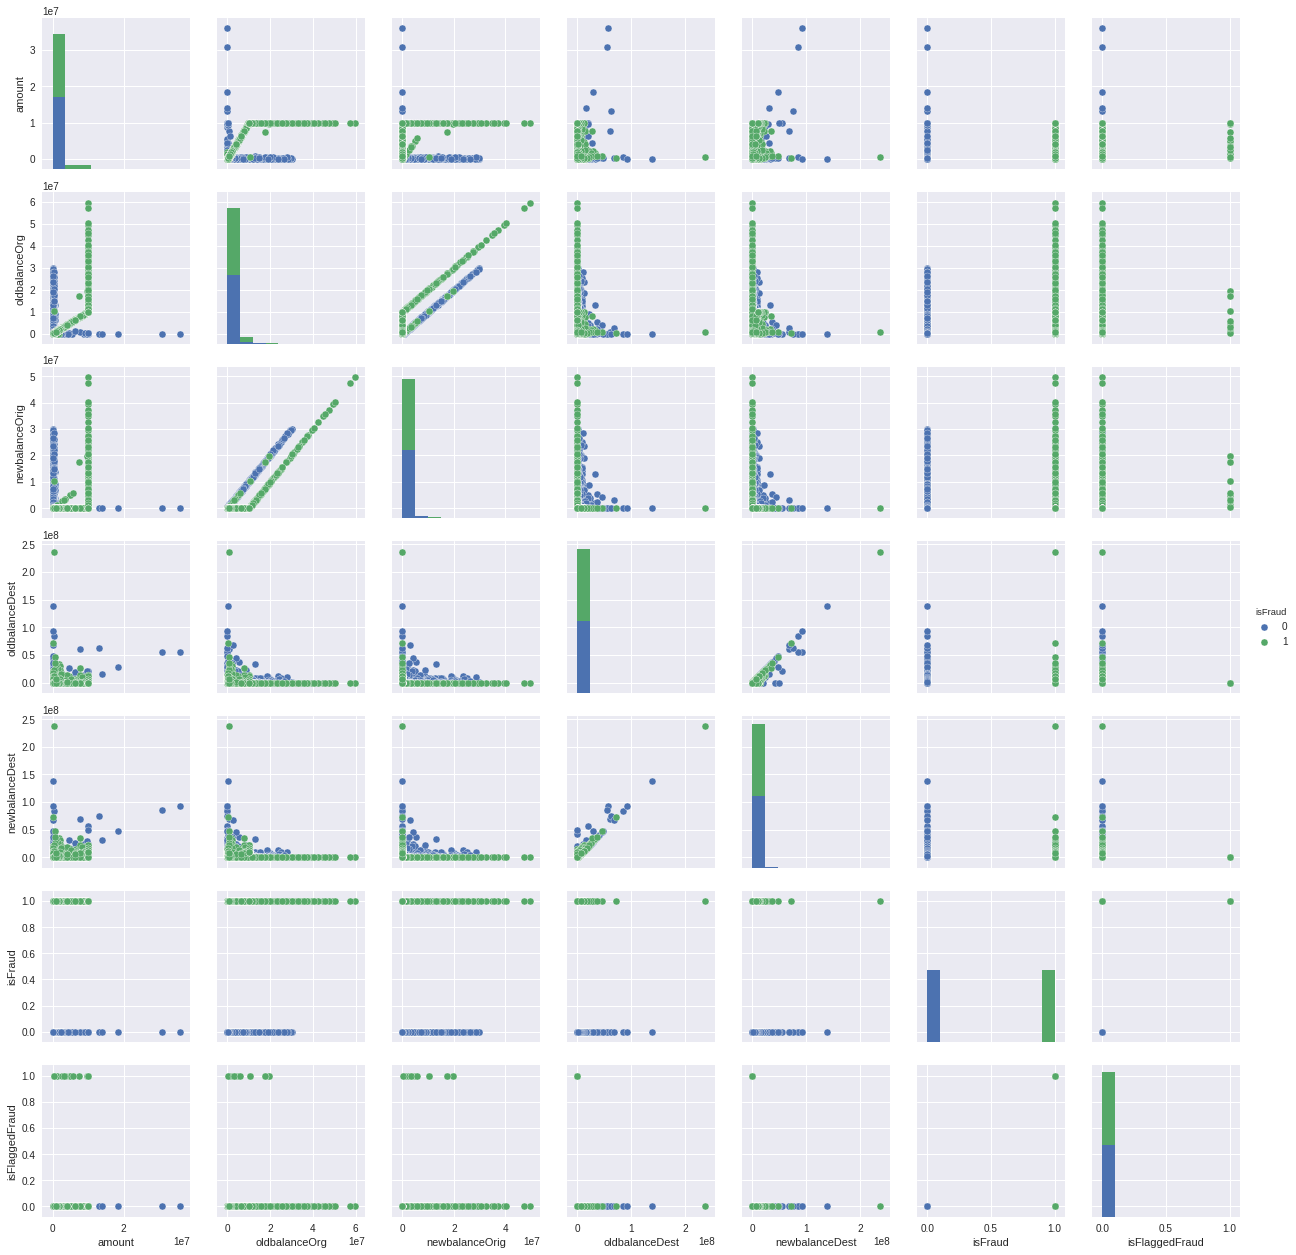

In [88]:
# Get indices of normal and fraudulent transactions
fraud_inds = np.array(paysim_data[paysim_data.isFraud==1].index)
normal_inds = paysim_data[paysim_data.isFraud==0].index

# Get a random subset of normal indices (same size as # of fraudulent transactions)
random_normal_inds = np.array(np.random.choice(normal_inds, fraudCount, replace=False))

# Join with fraudulent indices
joined_inds = np.concatenate([fraud_inds,random_normal_inds])

# Get the smaller dataset
small_data = paysim_data.iloc[joined_inds,:]

sns.pairplot(small_data[corr_cols], hue="isFraud")
plt.show()

In [89]:
print "Fraudlent transaction statistics:"
print paysim_data.iloc[fraud_inds,:].describe()

print "\n\nLegitimate transaction statistics:"
print paysim_data.iloc[normal_inds,:].describe()

Fraudlent transaction statistics:
              step        amount  oldbalanceOrg  newbalanceOrig  \
count  8213.000000  8.213000e+03   8.213000e+03    8.213000e+03   
mean    368.413856  1.467967e+06   1.649668e+06    1.923926e+05   
std     216.388690  2.404253e+06   3.547719e+06    1.965666e+06   
min       1.000000  0.000000e+00   0.000000e+00    0.000000e+00   
25%     181.000000  1.270913e+05   1.258224e+05    0.000000e+00   
50%     367.000000  4.414234e+05   4.389835e+05    0.000000e+00   
75%     558.000000  1.517771e+06   1.517771e+06    0.000000e+00   
max     743.000000  1.000000e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
count    8.213000e+03    8.213000e+03   8213.0     8213.000000  
mean     5.442496e+05    1.279708e+06      1.0        0.001948  
std      3.336421e+06    3.908817e+06      0.0        0.044097  
min      0.000000e+00    0.000000e+00      1.0        0.000000  
25%      0.000000e+00    0.000000e+00

### Some factors to consider testing:
* Splitting with different ratios than 50/50. The results in [Chan 1998](http://www.aaai.org/Papers/KDD/1998/KDD98-026.pdf) suggest that the 50/50 ratio minimizes the cost of investigating transactions flagged as fraudulent for various values of overhead cost when a meta-learning algorithm is applied.
* Training learners on 50/50 split subsets of the data then combining their predictions to form a final learner. There are multiple ways to combine the individual learners' predictions:
  * ~~Voting-based methods: let each classifier produce an output, weight these outputs and combine them in some way to obtain an overall decision (e.g. if doing binary classification take the mean of the outputs and assign a 0 if less than 0.5, and a 1 otherwise)~~
  * Meta-learner: get output from each learner for each example. Use these predictions as features and train another classifier on these.
* ~~Preprocessing the data (giving it mean 0 and std 1)~~
* Creating custom features:
  * Binary variable indicating if transaction was over a certain amount
  * ~~Binary variabes for categorical data?~~
* Cost-sensitive classifiers (e.g. [AdaCost](https://pdfs.semanticscholar.org/9ddf/bc2cc5c1b13b80a1a487b9caa57e80edd863.pdf)). See [costcla](https://pypi.python.org/pypi/costcla/0.5) for implementations of some of these methods.
* Ways of handling categorical data

### First let's just try comparing the results obtained using one 50/50 split and an equally sized set of random examples

In [90]:
# Drop columns that do not aid in classification
paysim_data.drop(['step','nameOrig','nameDest'],axis=1,inplace=True)

In [91]:
# Preprocessing:

# Drop transaction types that do not have any instances of fraud
df = paysim_data.loc[np.logical_or((paysim_data['type']=='CASH_OUT').values, (paysim_data['type']=='TRANSFER').values),:]
df = df.reset_index(drop=True,inplace=False)

# Convert the categorical variables TRANSFER and CASH_OUT to binary ones
from statsmodels.tools import categorical
types = np.array(df['type'])
cat = categorical(types,drop=True)
df['category'] = cat.argmax(1)   # 1 if TRANSFER, 0 if CASH_OUT
df.drop(['type'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

# New total number of examples
nExamples = df.shape[0]
print "New number of examples: %d" %nExamples


New number of examples: 2770409


In [92]:
# Splitting into training and testing:

# Split into target and features
X_full = df.ix[:, df.columns != 'isFraud']
Y_full = df.ix[:, df.columns =='isFraud']

# Drop transactions of amount 0
Y_full = Y_full[X_full['amount']!=0]
X_full = X_full[X_full['amount']!=0]
X_full.reset_index(drop=True,inplace=True)
Y_full.reset_index(drop=True,inplace=True)

# Subsample to get a 50/50 split of fraudulent and legitimate transactions:

# Get indices of normal and fraudulent transactions
fraud_inds = np.array(Y_full[Y_full.isFraud==1].index)
normal_inds = Y_full[Y_full.isFraud==0].index

# Get a random subset of normal indices (same size as # of fraudulent transactions)
random_normal_inds = np.array(np.random.choice(normal_inds, fraudCount, replace=False))

# Join with fraudulent indices
joined_inds = np.concatenate([fraud_inds,random_normal_inds])

# Get a random subset of indices of the same size as the 50/50 split
random_inds = np.array(np.random.choice(range(X_full.shape[0]),2*fraudCount,replace=False))

# Get the smaller dataset
small_X = X_full.iloc[joined_inds,:]
small_Y = Y_full.iloc[joined_inds,:]

# Get the random subset
rand_X = X_full.iloc[random_inds,:]
rand_Y = Y_full.iloc[random_inds,:]

# Split into testing and training
from sklearn.model_selection import train_test_split

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(small_X ,small_Y, test_size=0.33)
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(rand_X ,rand_Y, test_size=0.33)
X_train, X_test, y_train, y_test = train_test_split(X_full ,Y_full, test_size=0.33)

print "Number of examples in training set: %d" %(len(y_train_small))
print "Number of examples in test set: %d" %(len(y_test_small))

Number of examples in training set: 10994
Number of examples in test set: 5416


## Logistic regression
Since false negatives (missed fraudulent transactions) are so costly, we mainly focus on the recall score = TP / (TP + FN).

Function for visualizing the confusion matrix ([source](https://www.kaggle.com/joparga3/d/dalpozz/creditcardfraud/in-depth-skewed-data-classif-93-recall-acc-now)).

In [93]:
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Function for training logistic regression model and evaluating it
def train_logReg(X_train,y_train,X_test,y_test,weights=None):
    if weights is None:
        lr = LogisticRegression(C=0.01)
    else:
        lr = LogisticRegression(C=0.01,class_weight=weights)

    # Fit the model
    lr.fit(X_train,y_train.values.ravel())

    # Make predictions on test set
    y_pred = lr.predict(X_test)
    
    class_names = ['Legitimate','Fraudulent']
    print "Recall on training set: %f" %(recall_score(y_train.values.ravel(),lr.predict(X_train).ravel()))
    print "Recall on test set: %f" %(recall_score(y_test.values.ravel(),y_pred.ravel()))

    print "Test set stats: "
    print classification_report(y_test.values.ravel(),y_pred.ravel(),target_names=class_names)

    # Plot the confusion matrix for training and test sets
    
    
    # Train
    cm = confusion_matrix(y_train,lr.predict(X_train))
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix (train)')
    plt.show()

    # Test
    cm = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix (test)')
    plt.show()
    
    return lr

## 50/50 split:

Recall on training set: 0.971143
Recall on test set: 0.974321
Test set stats: 
             precision    recall  f1-score   support

 Legitimate       0.97      0.88      0.92      2729
 Fraudulent       0.89      0.97      0.93      2687

avg / total       0.93      0.93      0.93      5416



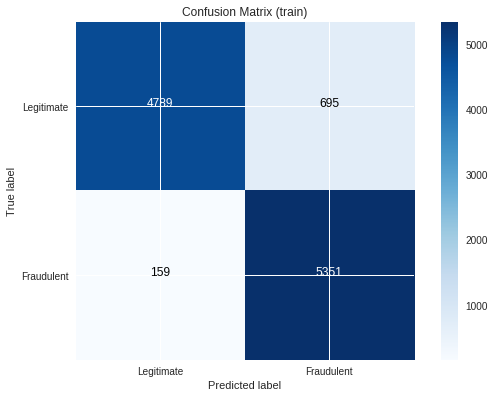

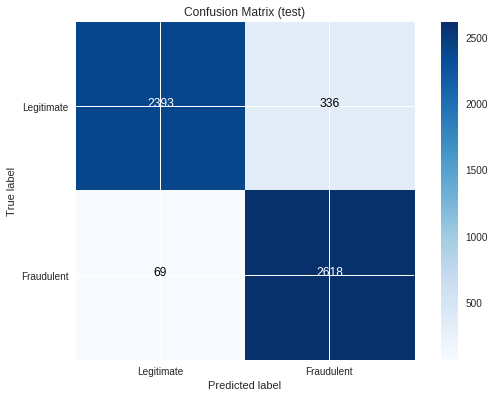

Results on full test data:
             precision    recall  f1-score   support

 Legitimate       1.00      0.88      0.93    911477
 Fraudulent       0.02      0.97      0.05      2753

avg / total       1.00      0.88      0.93    914230



In [94]:
# Run logistic regression on skewed and subsampled data sets and measure performance
# Consider changing class_penalty option or penalty option (from l2 to l1)
# Consider changing solver to sag (after preprocessing data)

lr = train_logReg(X_train_small,y_train_small,X_test_small,y_test_small)
# TODO: Use 5-fold cross validation to select a good value of the parameter C

# How well does this work on the full dataset?
y_pred = lr.predict(X_test)

class_names = ['Legitimate','Fraudulent']
print "Results on full test data:"
print classification_report(y_test.values.ravel(),y_pred.ravel(),target_names=class_names)

Observe that we can improve recall by giving the fraudulent cases heigher weight, but this has the effect of increasing the number of legitimate transactions that are flagged as fraudulent substantially.

Recall on training set: 0.992196
Recall on test set: 0.990696
Test set stats: 
             precision    recall  f1-score   support

 Legitimate       0.99      0.79      0.88      2729
 Fraudulent       0.82      0.99      0.90      2687

avg / total       0.91      0.89      0.89      5416



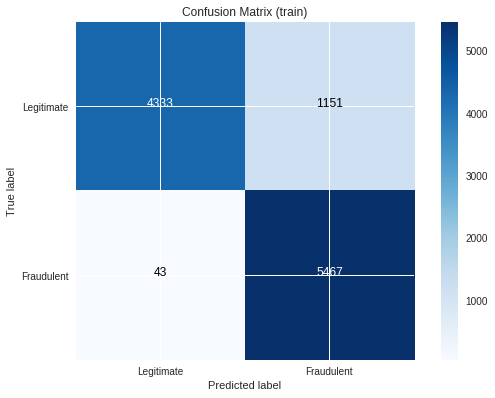

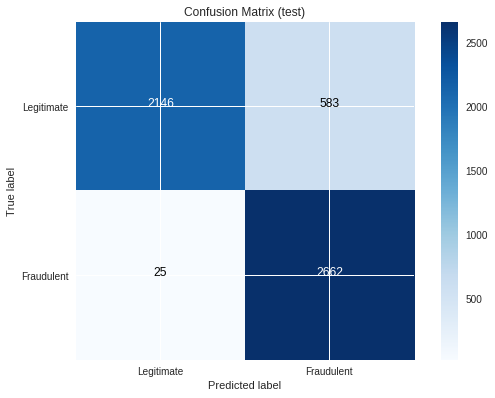

LogisticRegression(C=0.01, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [95]:
# Weight fraudulent cases higher
weights = {0: 1., 1: 10.}
train_logReg(X_train_small,y_train_small,X_test_small,y_test_small,weights)

## Training on the random dataset (a random sample of the original data)

Recall on training set: 0.965517
Recall on test set: 1.000000
Test set stats: 
             precision    recall  f1-score   support

 Legitimate       1.00      1.00      1.00      5400
 Fraudulent       1.00      1.00      1.00        21

avg / total       1.00      1.00      1.00      5421



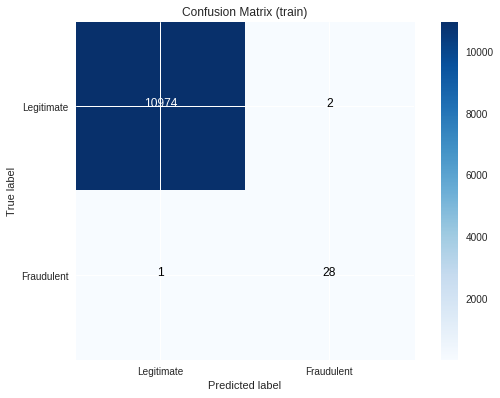

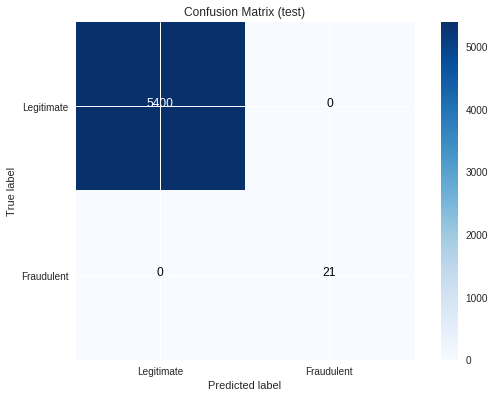

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [96]:
train_logReg(X_train_rand,y_train_rand,X_test_rand,y_test_rand)

## Train on the full dataset

Recall on training set: 0.721161
Recall on test set: 0.717762
Test set stats: 
             precision    recall  f1-score   support

 Legitimate       1.00      1.00      1.00    911477
 Fraudulent       0.54      0.72      0.62      2753

avg / total       1.00      1.00      1.00    914230



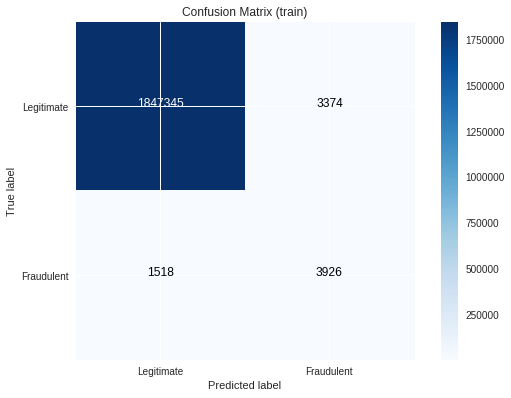

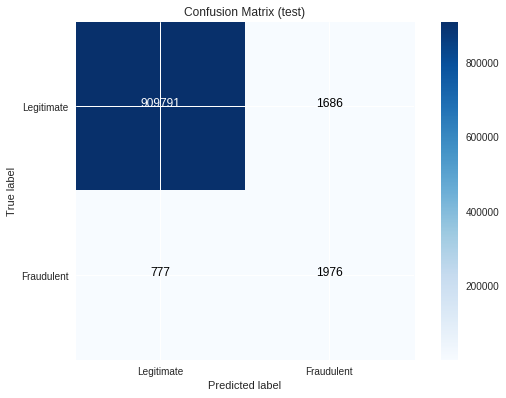

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
weights={0:1.0, 1:10.0}
train_logReg(X_train,y_train,X_test,y_test)

## Scaling the data so that features have mean 0 and std 1

From the results below it is apparent that this is not the approach we want to take.
Note: using robust_scale instead of scale improves performance considerably because of outliers in the data.

Recall on training set: 0.769691
Recall on test set: 0.782285
Test set stats: 
             precision    recall  f1-score   support

 Legitimate       0.78      0.77      0.78      2729
 Fraudulent       0.77      0.78      0.78      2687

avg / total       0.78      0.78      0.78      5416



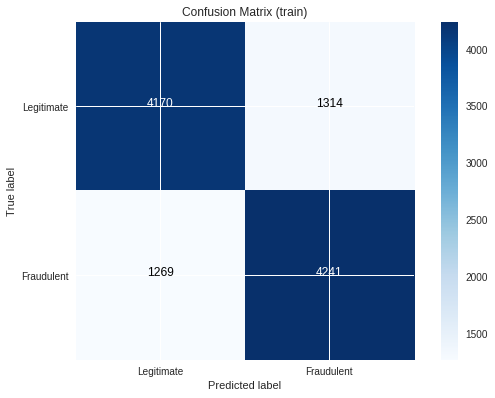

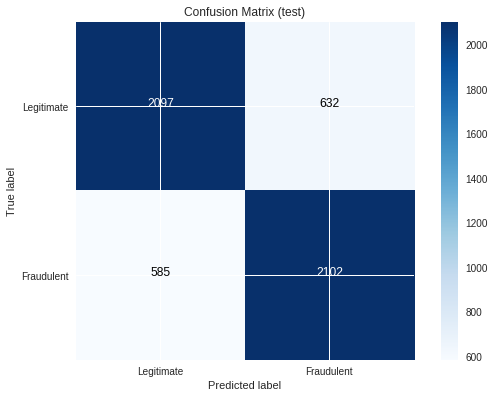

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
from sklearn import preprocessing

X_train_small_scaled = pd.DataFrame(preprocessing.robust_scale(X_train_small.values))
X_train_small_scaled[[5,6]] = X_train_small[[5,6]].values

X_test_small_scaled = pd.DataFrame(preprocessing.robust_scale(X_test_small.values))
X_test_small_scaled[[5,6]] = X_test_small[[5,6]].values


train_logReg(X_train_small_scaled,y_train_small,X_test_small_scaled,y_test_small)

## Scaling the examples so each has unit l2 norm
This doesn't really help either.

Recall on training set: 0.818512
Recall on test set: 0.826572
Test set stats: 
             precision    recall  f1-score   support

 Legitimate       0.84      0.93      0.88      2729
 Fraudulent       0.92      0.83      0.87      2687

avg / total       0.88      0.88      0.88      5416



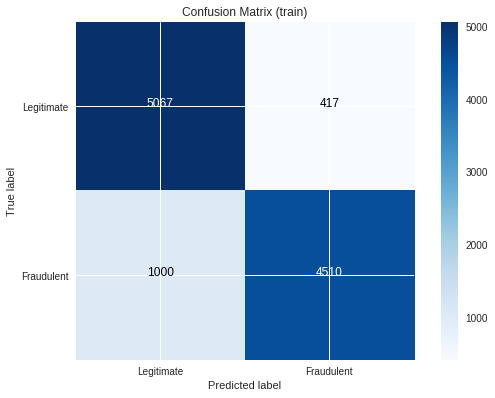

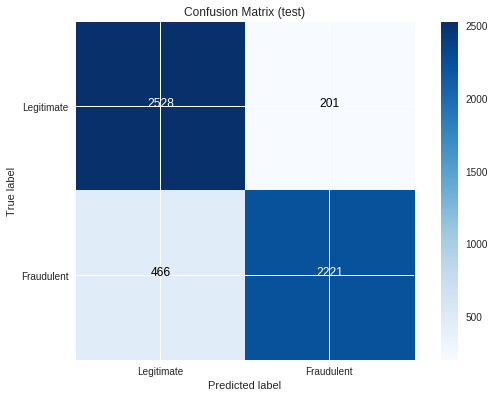

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [99]:
X_train_small_norm = pd.DataFrame(preprocessing.normalize(X_train_small.values,norm='l2'))
X_train_small_norm[[5,6]] = X_train_small[[5,6]].values

X_test_small_norm = pd.DataFrame(preprocessing.normalize(X_test_small.values,norm='l2'))
X_test_small_norm[[5,6]] = X_test_small[[5,6]].values


train_logReg(X_train_small_norm,y_train_small,X_test_small_norm,y_test_small)

## Trying out some other methods
Here we experiment with a set of methods and see which does best on the 50/50 split dataset. First we break up the full dataset into a training and testing set.

In [100]:
# First we split the whole dataset into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X_full ,Y_full, test_size=0.33)

# X_train.reset_index(drop=True,inplace=True)
# X_test.reset_index(drop=True,inplace=True)
# y_train.reset_index(drop=True,inplace=True)
# y_test.reset_index(drop=True,inplace=True)

# Then we figure out how many fraudulent cases we have in the training set
fraud_inds = np.array(y_train[y_train.isFraud==1].index)
normal_inds = np.array(y_train[y_train.isFraud==0].index)

X_train_fraud = X_train.ix[fraud_inds].reset_index(drop=True,inplace=False)
y_train_fraud = y_train.ix[fraud_inds].reset_index(drop=True,inplace=False)
X_test_fraud = X_test.ix[fraud_inds].reset_index(drop=True,inplace=False)
y_test_fraud = y_test.ix[fraud_inds].reset_index(drop=True,inplace=False)

X_train_normal = X_train.ix[normal_inds].reset_index(drop=True,inplace=False)
y_train_normal = y_train.ix[normal_inds].reset_index(drop=True,inplace=False)
X_test_normal = X_test.ix[normal_inds].reset_index(drop=True,inplace=False)
y_test_normal = y_test.ix[normal_inds].reset_index(drop=True,inplace=False)

# Partition up the training data into groups having an equal ratio of fraudulent and legitimate transactions
nFraud = len(fraud_inds)       # Number of fraudulent transactions
nLeg = len(normal_inds)        # Number of legitimate transactions
nSplits = nLeg / nFraud + 1    # Number of chunks data is broken into

# Define some functions that will be useful

# Append fraudulent transactions to normal ones specified by inds
def append_fraud(X_fraud,X_normal,y_fraud,y_normal,inds):
    return np.concatenate((X_fraud.values,X_normal.ix[inds].values)), np.concatenate((y_fraud.values,y_normal.ix[inds].values)).ravel()

# Get accuracy, recall, precision, and f1 scores
def get_scores(y_test,y_pred):
    return accuracy_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred), f1_score(y_test,y_pred)

# Define one random 50/50 split set for some initial tests
inds = np.random.choice(X_train_normal.shape[0],nFraud)
X_train_small, y_train_small = append_fraud(X_train_fraud,X_train_normal,y_train_fraud,y_train_normal,inds)

Here we train a random forest, decision tree, gradient boosting ensemble, logistic regression model, and a weighted logistic regression model on a small 50:50 split subset of the data then evaluate the model's performances on the test set.

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Make a dictionary of classifiers where we can also store outputs (add more or modify parameters as needed)
weights = {0: 1., 1: 10.}
classifiers = {"RF" : {"f": RandomForestClassifier()},
               "DT" : {"f": DecisionTreeClassifier()},
               "LR" : {"f": LogisticRegression()},
               "GB" : {"f": GradientBoostingClassifier()},
               "LRW" : {"f": LogisticRegression(class_weight=weights)}}

# Fit the classifiers and make predictions
for model in classifiers.keys():
    # Fit the models
    classifiers[model]["f"].fit(X_train_small,y_train_small)
    
    # Make predictions with each
    classifiers[model]["p"] = classifiers[model]["f"].predict(X_test)

# Measure performance of each (add more as needed)
from sklearn.metrics import accuracy_score, f1_score, precision_score

metrics = {"rec": recall_score, "acc": accuracy_score, "f1": f1_score, "prec": precision_score}
results = pd.DataFrame(columns=metrics.keys())

# Compute metrics for each classifier on full dataset
for model in classifiers.keys():
    results.loc[model] = [metrics[metric](y_test.values.ravel(),classifiers[model]["p"]) for metric in metrics.keys()]

print results

          acc       rec      prec        f1
RF   0.982023  0.989907  0.138959  0.243707
LR   0.882760  0.971215  0.023682  0.046236
DT   0.983474  0.990654  0.149430  0.259689
LRW  0.784121  0.993271  0.013285  0.026219
GB   0.969824  0.996636  0.088147  0.161968


The random forest, decision tree, and gradient boosting methods appear to do very well on the small 50/50 split testing set. Let's look at their confusion matrices.

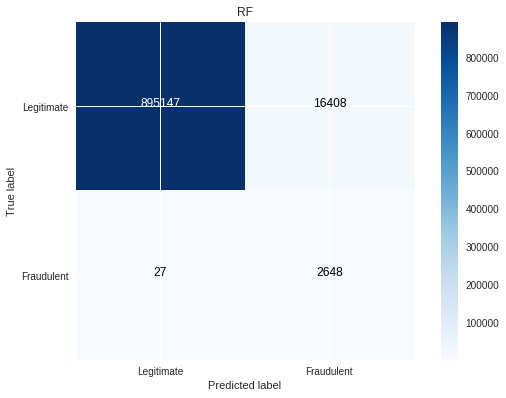

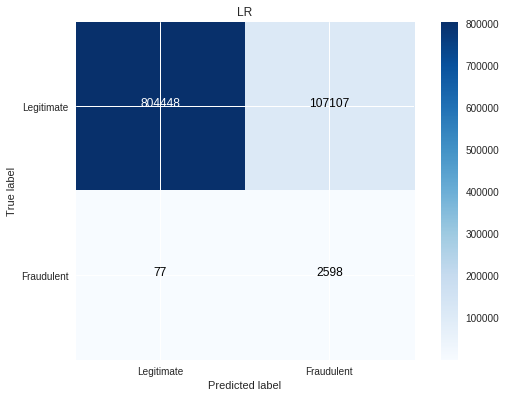

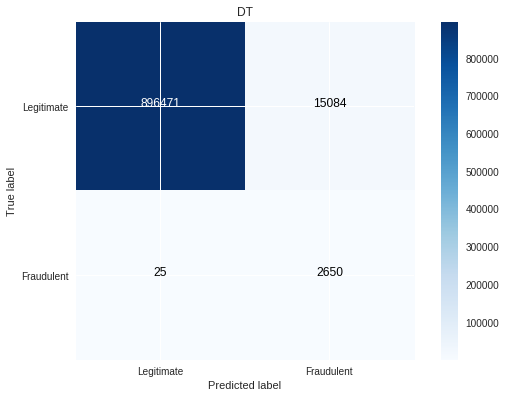

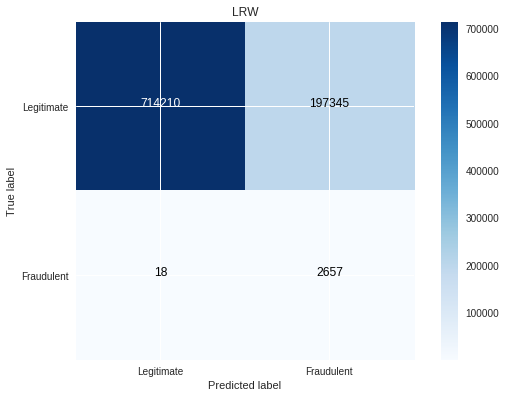

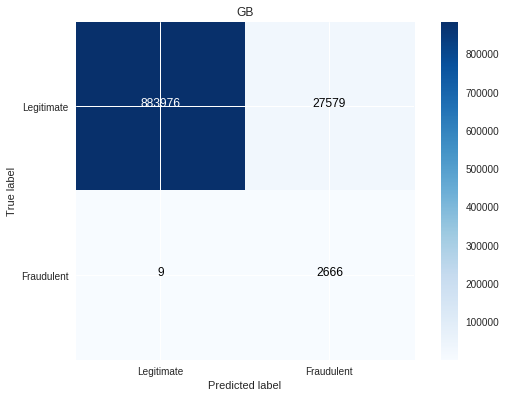

In [102]:
# Print some confusion matrices for the small dataset
class_names = ["Legitimate", "Fraudulent"]
for model in classifiers.keys():
    cm = confusion_matrix(y_test,classifiers[model]["p"])
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, title=model)
    plt.show()

Now let's test them on the full testing set.

In [103]:
full_results = pd.DataFrame(columns=metrics.keys())

for model in classifiers.keys():
    classifiers[model]["p_full"] = classifiers[model]["f"].predict(X_test)
    full_results.loc[model] = [metrics[metric](y_test.values.ravel(),classifiers[model]["p_full"]) for metric in metrics.keys()]
    
print full_results

          acc       rec      prec        f1
RF   0.982023  0.989907  0.138959  0.243707
LR   0.882760  0.971215  0.023682  0.046236
DT   0.983474  0.990654  0.149430  0.259689
LRW  0.784121  0.993271  0.013285  0.026219
GB   0.969824  0.996636  0.088147  0.161968


These precision scores are less than desirable. A low precision score means that most of the transactions flagged as fraudulent are actually legitimate. See the confusion matrices below. The f1 score is a weighted average of the precision and recall scores: $$F1 = 2 \frac{p\times r}{p+r}.$$

Note that because there are so few instances of fraud, a classifier which predicts every transaction to be legitimate does very well:

In [104]:
print "Accuracy of constant classifier: %f" %accuracy_score(y_test.values.ravel(),np.zeros(X_test.shape[0]))
# Note" all other scores are 0

Accuracy of constant classifier: 0.997074


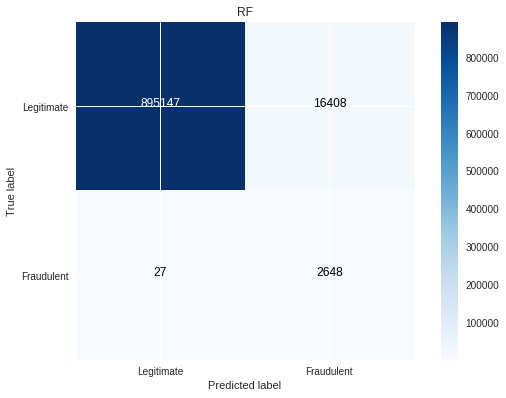

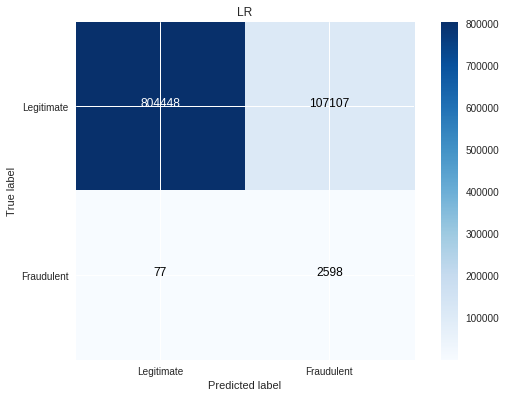

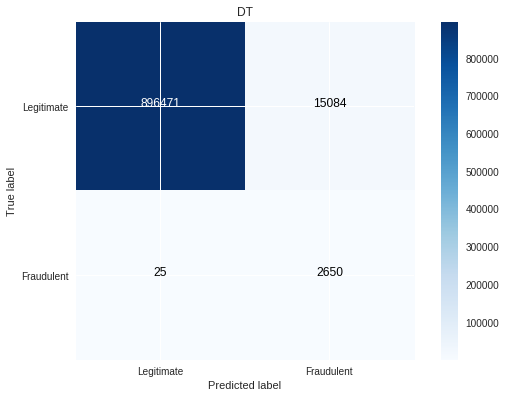

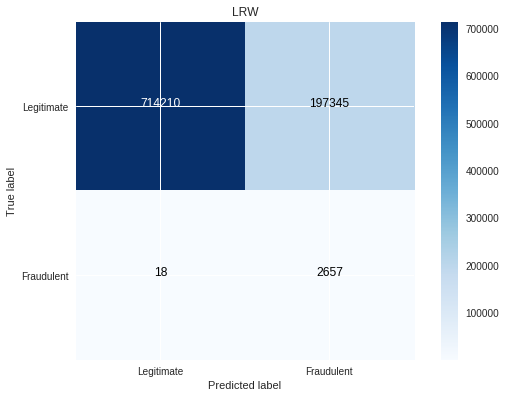

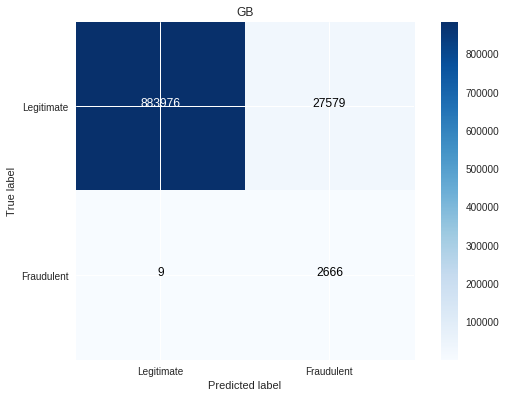

In [105]:
# Corresponding confusion matrices
for model in classifiers.keys():
    cm = confusion_matrix(y_test,classifiers[model]["p_full"])
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, title=model)
    plt.show()

## Now let's try to form a meta-learner by combining many learners trained on different 50/50 splits of the data.

Now let's train many classifiers on each partition of the data. (This takes much longer to run than the previous case. Maybe consider training a smaller number of classifiers by randomly selecting 50/50 splits from training data). Note that this approach is easily *parallelizable*.

Consider looking into [sklearn.ensemble.VotingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) for combining weak learners of different types.

In [106]:
# If you want to use EVERY split, use this code (warning: this makes the next cell very slow)
# inds = [range(k*nFraud,(k+1)*nFraud) for k in range(nSplits-1)]
# inds.append(range((nSplits-1)*nFraud,nLeg))

# Let's try subsampling so that we don't use every possible split
nSamples = 10                  # Number of 50/50 splits (and classifiers) to use
samples = np.random.choice(range(nSplits-1),nSamples,replace=False)
inds_subsamp = [range(k*nFraud,(k+1)*nFraud) for k in samples]

# -------------------------------------------------------------------------
#      This is where you specify the classifier to be used!
# -------------------------------------------------------------------------

# All random forests/decision trees
classifiers = [RandomForestClassifier() for k in xrange(nSamples)]

# Half random forests and decision trees
# classifiers = [RandomForestClassifier() for k in xrange(nSamples/2)]
# for k in xrange(nSamples/2,nSamples):
#     classifiers.append(DecisionTreeClassifier())

y_pred = np.zeros(X_test.shape[0])         # Aggregate predictions
y_prob = np.zeros((X_test.shape[0],2))     # Aggregate probabilities
sub_scores = {"acc": [], "rec": [], "prec": [], "f1": []}

for k in range(nSamples):
    # Fit the model
    classifiers[k].fit(*append_fraud(X_train_fraud,X_train_normal,y_train_fraud,y_train_normal,inds_subsamp[k]))

    # Keep running total of predictions on the test set (to be averaged at the end)
    temp_pred = classifiers[k].predict(X_test)
    y_pred += temp_pred
    y_prob += classifiers[k].predict_proba(X_test)
    
    # Store some statistics on scores for individual learners
    for metric in metrics.keys():
        sub_scores[metric].append(metrics[metric](y_test,temp_pred))

# Average predictions
y_pred /= float(nSamples)

# Map to 0 if less than 0.5, 1 otherwise
y_pred[y_pred < 0.5] = 0.
y_pred[y_pred >= 0.5] = 1.

y_pred_prob = np.argmax(y_prob,axis=1)

# Check statistics for meta-learner
print "\tMeta-learner statistics (on global test set)"
for metric in metrics.keys():
    print "%s(avg): %f"%(metric, metrics[metric](y_test,y_pred))
    print "%s(prob): %f"%(metric, metrics[metric](y_test,y_pred_prob))

# Check statistics for individual learners
print "\n\n\tIndividual learner statistics (on global test set)"
for metric in metrics.keys():
    print metric
    print "\tMean: %f" %np.mean(sub_scores[metric])
    print "\tstd: %f" %np.std(sub_scores[metric])
    print "\tmin: %f" %np.amin(sub_scores[metric])
    print "\tmax: %f\n" %np.amax(sub_scores[metric])

	Meta-learner statistics (on global test set)
acc(avg): 0.983338
acc(prob): 0.982520
rec(avg): 0.994393
rec(prob): 0.995140
prec(avg): 0.148786
prec(prob): 0.142888
f1(avg): 0.258843
f1(prob): 0.249894


	Individual learner statistics (on global test set)
acc
	Mean: 0.982953
	std: 0.000882
	min: 0.981620
	max: 0.984478

rec
	Mean: 0.989533
	std: 0.001409
	min: 0.986168
	max: 0.991402

prec
	Mean: 0.145702
	std: 0.006593
	min: 0.136282
	max: 0.157466

f1
	Mean: 0.253945
	std: 0.009985
	min: 0.239569
	max: 0.271696



### Let's try varying the number of learners.

In [107]:
nSamplesArr = [10, 15, 25, 50, 100]     # Number of 50/50 splits (and classifiers) to use
scores = {"acc": [], "rec": [], "prec": [], "f1": []}


for nSamples in nSamplesArr:
    samples = np.random.choice(range(nSplits-1),nSamples,replace=False)
    inds_subsamp = [range(k*nFraud,(k+1)*nFraud) for k in samples]
    
    # All decision trees / random forests
#     classifiers = [DecisionTreeClassifier() for k in xrange(nSamples)]
    
    # Half random forests and half decision trees
    classifiers = [RandomForestClassifier() for k in xrange(nSamples/2)]
    for k in xrange(nSamples/2,nSamples):
        classifiers.append(DecisionTreeClassifier())

    y_pred = np.zeros(X_test.shape[0])
    y_prob = np.zeros((X_test.shape[0],2))
    sub_scores = {"acc": [], "rec": [], "prec": [], "f1": []}

    for k in range(nSamples):
        # Fit the model
        classifiers[k].fit(*append_fraud(X_train_fraud,X_train_normal,y_train_fraud,y_train_normal,inds_subsamp[k]))

        # Keep running total of predictions on the test set (to be averaged at the end)
        temp_pred = classifiers[k].predict(X_test)
        y_pred += temp_pred
        y_prob += classifiers[k].predict_proba(X_test)

        # Store some statistics on scores for individual learners
        for metric in metrics.keys():
            sub_scores[metric].append(metrics[metric](y_test,temp_pred))

    # Average predictions
    y_pred /= float(nSamples)

    # Map to 0 if less than 0.5, 1 otherwise
    y_pred[y_pred < 0.5] = 0.
    y_pred[y_pred >= 0.5] = 1.
    
    y_pred_prob = np.argmax(y_prob,axis=1)

    # Check statistics for meta-learner
    for metric in metrics.keys():
        scores[metric].append(metrics[metric](y_test,y_pred))

    # Check statistics for individual learners
    print "\n\n\tIndividual learner statistics (number of learners = %d)"%nSamples
    for metric in metrics.keys():
        print metric
        print "\tMean: %f" %np.mean(sub_scores[metric])
        print "\tstd: %f" %np.std(sub_scores[metric])
        print "\tmin: %f" %np.amin(sub_scores[metric])
        print "\tmax: %f\n" %np.amax(sub_scores[metric])
    print "--------------------------------------------------------------------------------\n"


# Print statistics for all the meta-learners
for metric in metrics.keys():
    print "%s" %metric
    print "numLearners\tScore"
    for k in range(len(nSamplesArr)):
        print "%d:\t%f" %(nSamplesArr[k],scores[metric][k])
#     print "\nMean:%f" %(np.mean(scores[metric]))
#     print "\nstd:%f" %(np.std(scores[metric]))
    print "--------------------------------------------------------------------------------\n"



	Individual learner statistics (number of learners = 10)
acc
	Mean: 0.984259
	std: 0.001534
	min: 0.981697
	max: 0.986272

rec
	Mean: 0.989682
	std: 0.002232
	min: 0.986168
	max: 0.994019

prec
	Mean: 0.156693
	std: 0.012965
	min: 0.136444
	max: 0.174446

f1
	Mean: 0.270338
	std: 0.019381
	min: 0.239720
	max: 0.296587

--------------------------------------------------------------------------------



	Individual learner statistics (number of learners = 15)
acc
	Mean: 0.984612
	std: 0.000835
	min: 0.983045
	max: 0.986114

rec
	Mean: 0.988810
	std: 0.001777
	min: 0.986168
	max: 0.991402

prec
	Mean: 0.158878
	std: 0.007356
	min: 0.145808
	max: 0.172934

f1
	Mean: 0.273700
	std: 0.010942
	min: 0.254078
	max: 0.294448

--------------------------------------------------------------------------------



	Individual learner statistics (number of learners = 25)
acc
	Mean: 0.983760
	std: 0.000892
	min: 0.982228
	max: 0.985390

rec
	Mean: 0.989338
	std: 0.001886
	min: 0.985047
	max: 0.993645


### Results for RandomForestClassifier

numLearners | Accuracy | Recall | Precision | F1
 --- | -------- | ---------- | --------- | ---   
10 |  0.983520  |	0.996566 |	0.147821 |	0.257454
15 |  0.984521  |	0.994277 |	0.155656 |	0.269173
25 |  0.984547  |	0.995422 |	0.155994 |	0.269720
50 |  0.984696  |	0.996185 |	0.157365 |	0.271795
100|  0.984855  |	0.995422 |	0.158669 |	0.273710

### Results for DecisionTreeClassifier

numLearners | Accuracy | Recall | Precision | F1
 --- | ------------------- 
10 |  0.986299  |	0.998092 |	0.172822 |	0.294628
15 |  0.988374  |	0.998092 |	0.197583 |	0.329866
25 |  0.988493  |	0.998092 |	0.199223 |	0.332148
50 |  0.988075  |	0.998092 |	0.193591 |	0.324284
100|  0.988759  |	0.998092 |	0.202980 |	0.337353

### Results for half RandomForest, half DecisionTree ensemble (using majority voting)

numLearners | Accuracy | Recall | Precision | F1
 --- | ------------------- 
10 |  0.984814  |	0.996948 |	0.158469 |	0.273469
15 |  0.987237  |	0.997329 |	0.183117 |	0.309422
25 |  0.987647  |	0.997329 |	0.188044 |	0.316427
50 |  0.986954  |	0.997329 |	0.179854 |	0.304751
100|  0.987389  |	0.997329 |	0.184918 |	0.311989

## Comparison of Logistic regression model trained on full training set vs 50:50 split set

In [108]:
lr_full = LogisticRegression(C=0.01)
lr_sub = LogisticRegression(C=0.01)

lr_full.fit(X_train,y_train.values.ravel())

inds = range(583, 583 + nFraud)
lr_sub.fit(*append_fraud(X_train_fraud,X_train_normal,y_train_fraud,y_train_normal,inds))


y_pred_full = lr_full.predict(X_test)
y_pred_sub = lr_sub.predict(X_test)

scores_full = get_scores(y_test.values.ravel(), y_pred_full)
scores_sub = get_scores(y_test.values.ravel(), y_pred_sub)

print "Accuracy of full model: %f" %scores_full[0]
print "Recall of full model: %f" %scores_full[1]
print "Precision of full model: %f" %scores_full[2]
print "f1-score of full model: %f" %scores_full[3]

print "\n\nAccuracy of subsampled model: %f" %scores_sub[0]
print "Recall of subsampled model: %f" %scores_sub[1]
print "Precision of subsampled model: %f" %scores_sub[2]
print "f1-score of subsampled model: %f" %scores_sub[3]


Accuracy of full model: 0.997307
Recall of full model: 0.737196
Precision of full model: 0.528545
f1-score of full model: 0.615673


Accuracy of subsampled model: 0.893180
Recall of subsampled model: 0.973458
Precision of subsampled model: 0.025990
f1-score of subsampled model: 0.050629


# Taking cost into account
The financial costs of different classifications may not be well captured by these scores so we write a cost function to give us another way of comparing methods.

We assume there is some constant overhead cost associated with investigating a transaction marked as fraudulent, call it $C_a$. We assume the cost of missing a fraudulent transaction is equal to the amount of the transaction. Finally we assume that if a transaction of an amount less than $C_a$ is flagged as being fraudulent the financial institution simply ignores it since the cost of investigating it will outweigh the potential savings. Then the costs associated with each classification are given in the following table:

|					| Actual negative | Actual positive  |
| --------------------| ----------------| ---------------- |
| **Predicted negative**  | 0				  | $Amt_i$ |
| **Predicted positive**  | $I(Amt_i>C_a)\times C_a$| $\min \{C_a,Amt_i\}$  |

where $Amt_i$ is the amount of the transaction.

~~**Edit:** Due to arguments in [Correa Bahnsen et al. 2014](http://albahnsen.com/files/%20Improving%20Credit%20Card%20Fraud%20Detection%20by%20using%20Calibrated%20Probabilities%20-%20Publish.pdf) we will use the following cost breakdown:~~

|					| Actual negative | Actual positive  |
| --------------------| ----------------| ---------------- |
| **Predicted negative**  | 0				  | $Amt_i$ |
| **Predicted positive**  | $C_a$| $C_a$  |

In [109]:
# Apply costfun to array (row = [amount, label, predicted_label, overhead])
def costArrFun(row):
    if row[1]==0:
        # True negative
        if row[2]==0:
            return 0.0
        # False positive
        else:
            if row[0] > row[3]:
                return row[3]
    else:
        # False negative
        if row[2] == 0:
            return row[0]
        # True positive
        else:
            return (row[0] if (row[0] <= row[3]) else row[3])


# # Old cost function (first table above)

# amounts should be a column of values of each transaction
def costFun(amounts,labels,predicted_labels,overhead,scale=10000.0):    
    # Scale is factor by which to divide quantities to prevent overflow
    cost = 0.0
    scaled_overhead = overhead / scale
    for k in xrange(len(amounts)):
        if labels[k]==0:
            # True negative
            if predicted_labels[k]==0:
                continue
            # False positive
            else:
                if amounts[k] > overhead:
                    cost += scaled_overhead
        else:
            # False negative
            if predicted_labels[k] == 0:
                cost += (amounts[k] / scale)
            # True positive
            else:
                cost += (amounts[k]/scale if (amounts[k] <= overhead) else scaled_overhead)
    
#     Vectorized implementation (apply function that accomplishes the above to each row)

#     ***This is way slower***
#     cost = np.sum(np.apply_along_axis(costArrFun,1,np.stack((amounts,labels,predicted_labels,overhead*np.ones_like(labels)),axis=1)))

    return cost * scale



# New cost function (second table above)

# def costFun(amounts,labels,predicted_labels,overhead,scale=10000.0):    
#     # Scale is factor by which to divide quantities to prevent overflow
#     cost = 0.0
#     scaled_overhead = overhead / scale
#     for k in xrange(len(amounts)):
#         # Predicted fraud (True positive or false positive)
#         if predicted_labels[k]==1:
#             cost += scaled_overhead
#         # False negative
#         elif labels[k]==1:
#             cost += (amounts[k] / scale)
    
#     return cost

## Model savings

We define the savings of a method by the difference in costs between the classifications of the dummy-classifier (which labels every transaction as legitimate) and those of a given model. First we take a look at the distribution of transaction amounts to get an idea of a reasonable place to set overhead.

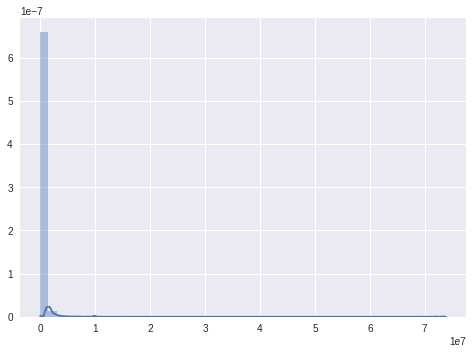

In [110]:
sns.distplot(X_test['amount'].values)
plt.show()

Since most of the transactions involve amounts of at least $10^4$, we set overhead to be $10^3$ for now.

Let's determine the cost of dummy classifiers that either predict all negatives or all positives.

In [111]:
overhead = 10000.0

dummy_cost_pos = (1.e4) * costFun(X_test['amount'].values,y_test.values.ravel(),np.ones_like(y_test.values.ravel()),overhead)
print "Cost of dummy classifier (all positives): %f" %(dummy_cost_pos)

dummy_cost_neg = (1.e4) * costFun(X_test['amount'].values,y_test.values.ravel(),np.zeros_like(y_test.values.ravel()),overhead)
print "Cost of dummy classifier (all negatives): %f" %(dummy_cost_neg)

Cost of dummy classifier (all positives): 88804653825199.953125
Cost of dummy classifier (all negatives): 39379029742700.015625


For overhead = 10,000 it appears the classifier that predicts every transaction to be fraudulent is actually cheaper than the one that marks everything as fradulent!
Let's flesh out how the costs of the dummy classifiers vary as we change the fixed overhead cost.

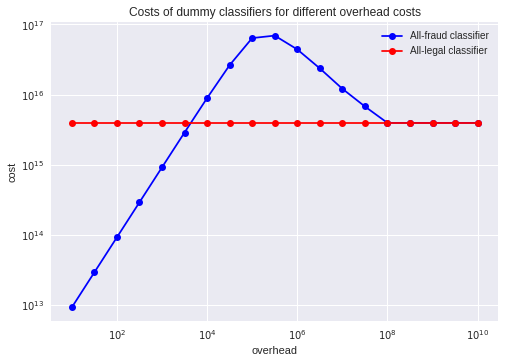

In [112]:
# Compute the costs for various values of overhead
pos_costs = []
neg_costs = []
overheadAmounts = np.logspace(1,10,19)
rescale = 1.e6
for overhead in overheadAmounts:
    pos_costs.append(rescale * costFun(X_test['amount'].values,y_test.values.ravel(),np.ones_like(y_test.values.ravel()),overhead,rescale))
    neg_costs.append(rescale * costFun(X_test['amount'].values,y_test.values.ravel(),np.zeros_like(y_test.values.ravel()),overhead,rescale))

plt.loglog(overheadAmounts,pos_costs,'b-o',overheadAmounts,neg_costs,'r-o')
plt.xlabel('overhead')
plt.ylabel('cost')
plt.legend(['All-fraud classifier','All-legal classifier'])
plt.title('Costs of dummy classifiers for different overhead costs')
plt.show()

"The all-legal classifier cost is constant because the cost it incurs is simply the sum of all the fraudulent transaction amounts, independent of the overhead cost. We see that for low overhead costs the all-fraud classifier is actually cheaper. This is because it is cheap enough, in this regime, to audit a transaction that financial institutions can afford to manually check every one. For mid-range values of *overhead*, the all-fraud classifier is more expensive than the all-legal one because the overhead cost is such that the financial institution still has to check many of the false positives (those whose amounts exceed *overhead*). As *overhead* is increased further, there are fewer and fewer false positives whose amounts are greater than *overhead*, so the cost begins to decrease. Eventually the two classifiers give the same result (the sum of all the fraudulent transactions)."

## What about the other algorithms?
Now let's compare savings among the algorithms we've been testing for different overhead costs. First the vanilla ones.

In [148]:
# Make a dictionary of classifiers where we can also store outputs (add more or modify parameters as needed)
weights = {0: 1., 1: 10.}
classifiers = {"RF" : {"f": RandomForestClassifier()},
               "DT" : {"f": DecisionTreeClassifier()},
               "LR" : {"f": LogisticRegression()},
               "GB" : {"f": GradientBoostingClassifier()},
               "LRW" : {"f": LogisticRegression(class_weight=weights)}}

# Fit the classifiers and make predictions
model_costs = {}
for model in classifiers.keys():
    # Fit the models
    classifiers[model]["f"].fit(X_train_small,y_train_small)

    # Make predictions with each
    classifiers[model]["p"] = classifiers[model]["f"].predict(X_test)
    
    # Initialize a list which will later store costs of each model
    model_costs[model] = []

# Measure performance of each (add more as needed)
from sklearn.metrics import accuracy_score, f1_score, precision_score

metrics = {"rec": recall_score, "acc": accuracy_score, "f1": f1_score, "prec": precision_score}
results = pd.DataFrame(columns=metrics.keys())

# Compute metrics for each classifier on full dataset
for model in classifiers.keys():
    results.loc[model] = [metrics[metric](y_test.values.ravel(),classifiers[model]["p"]) for metric in metrics.keys()]

print "Metrics for each of the models:"
print results

# Compute costs for various overhead cost constants
overheadAmounts = np.logspace(1,8,8)
rescale = 1.e6
model_costs['dummy_pos'] = []
model_costs['dummy_neg'] = []
for overhead in overheadAmounts:
    pos_cost = rescale * costFun(X_test['amount'].values,y_test.values.ravel(),np.ones_like(y_test.values.ravel()),overhead,rescale)
    neg_cost = rescale * costFun(X_test['amount'].values,y_test.values.ravel(),np.zeros_like(y_test.values.ravel()),overhead,rescale)
    model_costs['dummy_pos'].append(pos_cost)
    model_costs['dummy_neg'].append(neg_cost)
    
    print "\n\nCosts and savings for the models using overhead=%f" %overhead
    print "Dummy cost (all-legal): %f\n" %neg_cost
    costArr = []
    for model in classifiers.keys():
        costArr.append(rescale*costFun(X_test['amount'].values,y_test.values.ravel(),classifiers[model]["p"],overhead,rescale))
        model_costs[model].append(costArr[-1])
        
    results['cost'] = costArr
    results['savings'] = [neg_cost - cost for cost in costArr]
    print results[['cost','savings']]

Metrics for each of the models:
          acc       rec      prec        f1
RF   0.981663  0.987290  0.136338  0.239590
LR   0.882760  0.971215  0.023682  0.046236
DT   0.983950  0.990654  0.153197  0.265358
LRW  0.784121  0.993271  0.013285  0.026219
GB   0.969845  0.997383  0.088257  0.162164


Costs and savings for the models using overhead=10.000000
Dummy cost (all-legal): 3937902974269994.500000

             cost       savings
RF   4.304019e+12  3.933599e+15
LR   5.699807e+13  3.880905e+15
DT   4.910638e+12  3.932992e+15
LRW  4.559012e+12  3.933344e+15
GB   2.707315e+12  3.935196e+15


Costs and savings for the models using overhead=100.000000
Dummy cost (all-legal): 3937902974269994.500000

             cost       savings
RF   6.046609e+12  3.931856e+15
LR   6.686515e+13  3.871038e+15
DT   6.465968e+12  3.931437e+15
LRW  2.254728e+13  3.915356e+15
GB   5.427579e+12  3.932475e+15


Costs and savings for the models using overhead=1000.000000
Dummy cost (all-legal): 393790297426999

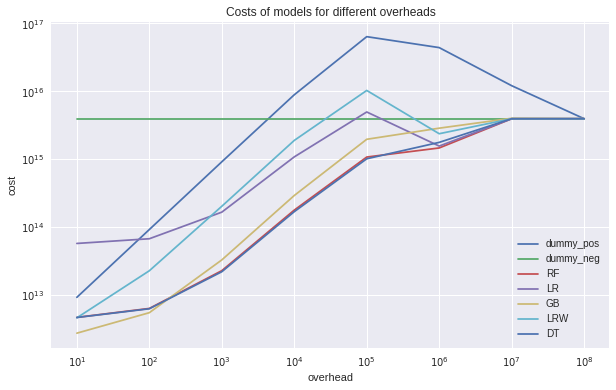

In [132]:
# Plot the costs of the models for different overhead amounts
plt.figure(1, figsize=(10,6))
for model in model_costs.keys():
    plt.loglog(overheadAmounts,model_costs[model])

plt.xlabel('overhead')
plt.ylabel('cost')
plt.title('Costs of models for different overheads')
plt.legend(model_costs.keys())
plt.show()

# # Plot recall scores for reference (recall (ha) that the dummy_pos has recall score 1 and dummy_neg has recall 0)
# plt.figure(2, figsize=(10,6))
# y_pos = range(results.shape[0])
# plt.bar(y_pos,results['rec'].values,alpha=0.75)
# plt.xticks(y_pos,classifiers.keys())
# plt.ylabel('Recall scores')
# plt.title('Recall scores for methods')
# plt.ylim((0.94,1))
# plt.show()

In [144]:
linestyles = ['-', '-', '-', '--','-','-',':']

plt.figure()
count = 0
for model in model_costs.keys():
    plt.loglog(overheadAmounts,model_costs[model],linestyles[count])
    count += 1

plt.xlabel('$C_a$')
plt.ylabel('Cost')
plt.title('Costs of models for different values of $C_a$')
plt.legend(model_costs.keys())

plt.savefig('overhead_comparison.pdf')

Based on this simple analysis it looks like the decision tree and random forest methods give the best performance for a range of values of overhead. The gradient boosting method appears to do best for small values of overhead.

## What about the meta learners?
Next we evaluate the costs of the meta learners. Each was able to do well with about 15 weak learners, so we will play it safe and use 25 for each.

In [115]:
nSamples = 25     # Number of 50/50 splits (and classifiers) to use
scores = {"acc": [], "rec": [], "prec": [], "f1": [], "cost": [] }
overhead = 1.e5


# for nSamples in nSamplesArr:
samples = np.random.choice(range(nSplits-1),nSamples,replace=False)
inds_subsamp = [range(k*nFraud,(k+1)*nFraud) for k in samples]

# All decision trees / random forests
classifiers = [RandomForestClassifier() for k in xrange(nSamples)]

# Half random forests and half decision trees
#     classifiers = [RandomForestClassifier() for k in xrange(nSamples/2)]
#     for k in xrange(nSamples/2,nSamples):
#         classifiers.append(DecisionTreeClassifier())

y_pred = np.zeros(X_test.shape[0])
y_prob = np.zeros((X_test.shape[0],2))

for k in range(nSamples):
    # Fit the model
    classifiers[k].fit(*append_fraud(X_train_fraud,X_train_normal,y_train_fraud,y_train_normal,inds_subsamp[k]))

    # Keep running total of predictions on the test set (to be averaged at the end)
    temp_pred = classifiers[k].predict(X_test)
    y_pred += temp_pred
    y_prob += classifiers[k].predict_proba(X_test)


# Average predictions
y_pred /= float(nSamples)

# Map to 0 if less than 0.5, 1 otherwise
y_pred[y_pred < 0.5] = 0.
y_pred[y_pred >= 0.5] = 1.

y_pred_prob = np.argmax(y_prob,axis=1)

# Check statistics for meta-learner
for metric in metrics.keys():
    scores[metric].append(metrics[metric](y_test,y_pred))

# Check cost for meta-learner
scores["cost"].append(rescale*costFun(X_test['amount'].values,y_test.values.ravel(),y_pred,overhead,rescale))

# Print metrics
for metric in scores.keys():
    print "%s:\t%f" %(metric, scores[metric][0])

acc:	0.985034
rec:	0.993645
cost:	975309353440149.625000
prec:	0.162838
f1:	0.279819


## Summary of costs for meta-learners with overhead = $10^5$
(we use $10^5$ since for this value of overhead the better methods are just barely able to achieve savings--if we chose a smaller value of, say $10^4$ the savings)

### Results for old cost function: 

Meta-learner   | Cost       | Recall
-----------    | -----      | -----
All-legal 	   | 3930053861 | 0.0
Decision Trees | 738527214  | 0.997023
Random Forests | 962265264  | 0.995534
Gradient Boost | 1775728004 | 0.995534

### ~~Results for new cost function:~~

Meta-learner   | Cost       | Recall
-----------    | -----      | -----
All-legal 	   | 3794818325 | 0.0
Decision Trees | 1283657521  | 0.996977
Random Forests | 1672709123  | 0.993575
Gradient Boost | 2903281353 | 0.995465

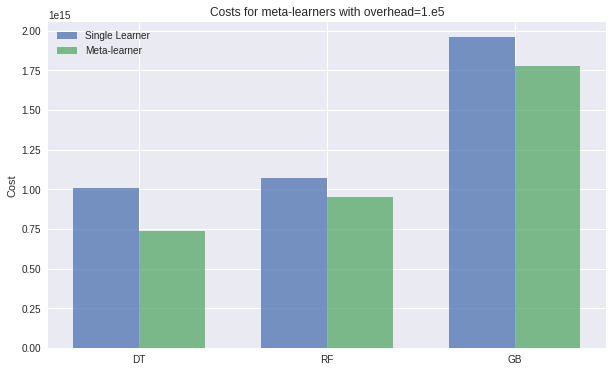

In [116]:
# results_meta = np.array([738527214, 962265264, 1775728004]) * 1.e6
results_meta = np.array([738527214*1.e6, 950673870220141, 1775728004*1.e6])

names_meta = ['DTs', 'RFs', 'GBs']
results_standard = []
names_standard = []

for model in names_meta:
    results_standard.append(model_costs[model[:-1]][4])
    names_standard.append(model[:-1])

plt.figure(1, figsize=(10,6))
y_pos = np.arange(len(results_meta))
bar_width = 0.35

plt.bar(y_pos, results_standard, bar_width, alpha=0.75, label='Single Learner')
plt.bar(y_pos+bar_width, results_meta, bar_width, alpha=0.75, label='Meta-learner')

plt.xticks(y_pos+bar_width/2.,names_standard)
plt.ylabel('Cost')
plt.title('Costs for meta-learners with overhead=1.e5')
plt.legend()
plt.show()